In [53]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import math

# PID

In [54]:
class PID:
    def __init__(
        self,
        Kp=1.0,
        Ki=0.0,
        Kd=0.0,
        bias=0,
        integral_max=9999,
        sample_time=0.1,
    ):
        self.kp = Kp
        self.ki = Ki
        self.kd = Kd
        self.bias = bias
        self.iMax = integral_max
        self.dt = sample_time

        self.error = 0
        self.integral = 0
        self.derivative = 0
        self.prevError = 0

        self.firstLoop = True

    def compute(self, setpoint, process_variable):
        self.error = setpoint - process_variable
        self.integral += self.error
        self.integral = min(max(self.integral, -self.iMax), self.iMax)
        self.integral *= self.dt

        self.derivative = 0 if self.firstLoop else (self.error - self.prevError)
        self.derivative /= self.dt
        self.prevError = self.error
        self.firstLoop = False

        return (
            (self.kp * self.error)
            + (self.ki * self.integral)
            + (self.kd * self.derivative)
            + self.bias
        )

# Thrust Allocator

In [55]:
import os.path
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.optimize import lsq_linear

# fmt: off
thruster_positions = np.array(
    [
        [-0.22, 0.238, -0.054],     # Front Left
        [0.22, 0.238, -0.054],      # Front Right
        [-0.234, -0.001, -0.107],   # Middle Left
        [0.234, -0.001, -0.107],    # Middle Right
        [-0.22, -0.217, -0.054],    # Rear Left
        [0.22, -0.217, -0.054],     # Rear Right
    ]
)

thruster_directions = np.array(
    [
        [1, 1, 0],                  # Front Left
        [-1, 1, 0],                 # Front Right
        [0, 0, 1],                  # Middle Left
        [0, 0, 1],                  # Middle Right
        [-1, 1, 0],                 # Rear Left
        [1, 1, 0],                  # Rear Right
    ]
)

thruster_biases = np.array([1.0,    # Front Left
                            1.0,    # Front Right
                            1.0,    # Middle Left
                            1.0,    # Middle Right
                            1.0,    # Rear Left
                            1.0])   # Rear Right
# fmt: on

thruster_directions = thruster_directions / np.linalg.norm(
    thruster_directions, keepdims=True, axis=1
)

I = np.array([0.205, 0.141, 0.205])

rosThrustMapPath = "src/controls_ws/controls_core/controls_core/thrust_map.csv"
wsThrustMapPath = "controls_core/thrust_map.csv"  # For debugging with test.ipynb
print(Path.cwd())

if os.path.exists(rosThrustMapPath):
    thrust_map = pd.read_csv(rosThrustMapPath).values
else:
    thrust_map = pd.read_csv(wsThrustMapPath).values


class ThrustAllocator:
    def __init__(
        self,
        thruster_positions=thruster_positions,
        thruster_directions=thruster_directions,
        mass=18.0,
        I=I,
        thrust_map=thrust_map,
    ):
        self.thruster_positions = thruster_positions
        self.thruster_directions = thruster_directions
        self.mass = mass
        self.I = I
        self.thrust_map = thrust_map

        self.unit_torque = np.cross(self.thruster_positions, self.thruster_directions)
        self.parameters = np.concatenate(
            (self.thruster_directions.T, self.unit_torque.T)
        )

    def getThrusts(self, linear_accelerations, angular_accelerations):
        linear_accelerations = np.array(linear_accelerations)
        angular_accelerations = np.array(angular_accelerations)

        self.expected_force = self.mass * linear_accelerations
        self.expected_torque = self.I * angular_accelerations
        self.goal = np.concatenate((self.expected_force, self.expected_torque))

        THRUSTER_CAP = 0.2

        lb = THRUSTER_CAP * np.min(self.thrust_map[:, 0])
        ub = THRUSTER_CAP * np.max(self.thrust_map[:, 0])

        thrust_newtons = lsq_linear(self.parameters, self.goal, bounds=(lb, ub)).x
        return thrust_newtons

    def getThrustPWMs(self, linear_accelerations, angular_accelerations):
        thrust_newtons = self.getThrusts(linear_accelerations, angular_accelerations)
        thrust_biased = thrust_newtons * thruster_biases

        thrust_converted = self.thrust_map[
            np.searchsorted(self.thrust_map[:, 0], thrust_biased, side="left"), 1
        ].astype(int)

        return thrust_converted


/home/advaypakhale/Documents/ros2_ws/src/controls_ws/controls_core


# Setup PIDs

In [56]:
yawPID = PID(Kp=10.0, Ki=0.0, Kd=5.0, sample_time=0.1).compute
depthPID = PID(Kp=10.0, Ki=0.0, Kd=10.0, sample_time=0.1).compute

# Other Paramters

In [57]:
DRAG_COEFF = 1
DRAG_ON = False
MASS = 18.0

TIME_SPAN = [0, 20]


# Initial and Desired Values

12 dimensional state $[x, y, z, r, p, y, x', y', z', r', p', y']$

In [58]:
init_state = [0.0, 0.0, 0.0, 0.0, 0.0, math.radians(90.0), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
target = [0.0, 0.0, -1.0, 0.0, 0.0, 0.0]

In [51]:
def f(t, s):
    vel = s[6:]
    # drag = (DRAG_COEFF/MASS)*(z[1]**2)
    az = depthPID(target[2], s[2])
    alpha_z = yawPID(target[5], s[5])
    acc = [0.0, 0.0, az, 0.0, 0.0, alpha_z]
    
    if DRAG_ON:
        az += drag
    return 

In [42]:
soln = solve_ivp(f, TIME_SPAN, z_0)

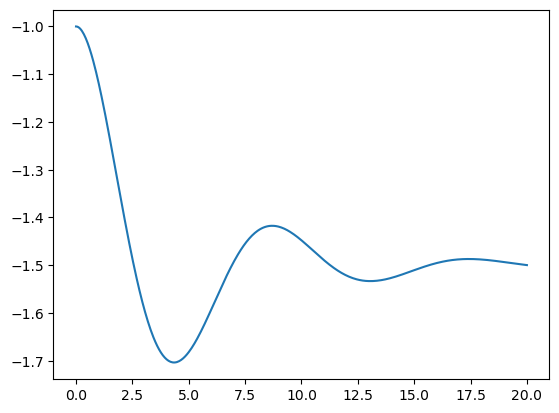

In [43]:
plt.plot(soln.t, soln.y[0])
# plt.ylim(-2, 0)
# plt.xlim(0, 1)